In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.linalg import hankel
import time
import os

In [2]:
def InversePowerMethod(A,tol, kIterMax,q0):
    
    import numpy as np
    
    n = A.shape[0]

    x = np.random.rand(n).reshape(-1,1)

    B = A.copy()

    error = 1
    
    #First Run
    for od in range(n):
            B[od,od] = A[od,od] - q0
        
    x = np.linalg.solve(B,x)
    x = x/np.linalg.norm(x)
    lamOld = x.T@A@x
    
    kIter = 1
    
    while kIter < kIterMax:
        
        #od = on diagonal
        for od in range(n):
            B[od,od] = A[od,od] - q0
        
        x = np.linalg.solve(B,x)
        x = x/np.linalg.norm(x)
        lamNew = x.T@A@x
        kIter = kIter + 1
        
        error = np.abs(lamNew - lamOld)
        if error < tol:
            return (x, lamNew, kIter)
        else:
            lamOld = lamNew
        
        
        
    return (x, lamNew, kIter)

In [3]:
def AnomalyDetectorSVD(signal, L, N_hankel, tolerance):
    from numpy.linalg import svd
    from numpy import zeros, where, nan, ones
    from statistics import mean,stdev
    from scipy.linalg import hankel
    
    x1 = signal.copy()
    xm = mean(signal)
    x0 = signal - xm


    H = hankel(x0[:L],x0[(L-1):N_hankel])
    u = svd(H,full_matrices=0)[0]
    p = u[:,-1]

    lp = len(p)
    lx = len(x0)
    N = lx-lp

    d0 = zeros(lx)
    d1 = zeros(lx)

    for k in range(N):
        d0[k+lp-1] = abs(p.T@x0[(k):(k+lp)])
        d1[N-k-1] = abs(p.T@x0[(lx-k-lp):(lx-k)])

    threshold0 = tolerance*stdev(d0)
    threshold1 = tolerance*stdev(d1)
   
    
    d0 = (d0 >= threshold0)
    d1 = (d1 >= threshold1)

    d = d0*d1

    di = where(d==1)
    y = nan*ones(lx)
    y[di] = x0[di]
    
    return(d,y,x0,x1,xm)

In [4]:
def AnomalyDetectorIPM(signal, L, N_hankel, tolerance, tolIPM, kIterMax, q0):
    from numpy import zeros, where, nan, ones
    from statistics import mean,stdev
    from scipy.linalg import hankel
    
    x1 = signal.copy()
    xm = mean(signal)
    x0 = signal - xm


    H = hankel(x0[:L],x0[(L-1):N_hankel])
    H1 = H@H.T
    p, lam, kIter = InversePowerMethod(A=H1, tol=tolIPM, 
                                       kIterMax = kIterMax, q0 = q0)

    lp = len(p)
    lx = len(x0)
    N = lx-lp

    d0 = zeros(lx)
    d1 = zeros(lx)

    for k in range(N):
        d0[k+lp-1] = abs(p.T@x0[(k):(k+lp)])
        d1[N-k-1] = abs(p.T@x0[(lx-k-lp):(lx-k)])

    threshold0 = tolerance*stdev(d0)
    threshold1 = tolerance*stdev(d1)
   
    
    d0 = (d0 >= threshold0)
    d1 = (d1 >= threshold1)

    d = d0*d1

    di = where(d==1)
    y = nan*ones(lx)
    y[di] = x0[di]
    
    return(d,y,x0,x1,xm)

In [5]:
def runTimesProd(signal, nruns, L, N_hankel):


    time_SVD_H = np.zeros(nruns)
    pTdotH_SVD_H = np.zeros(nruns)
    pTdotH1_SVD_H = np.zeros(nruns)
    
    time_SVD_H1 = np.zeros(nruns)
    pTdotH_SVD_H1 = np.zeros(nruns)
    pTdotH1_SVD_H1 = np.zeros(nruns)
    
    
    time_eigh = np.zeros(nruns)
    pTdotH_eigh = np.zeros(nruns)
    pTdotH1_eigh = np.zeros(nruns)
    
    
    time_IPM = np.zeros(nruns)
    pTdotH_IPM = np.zeros(nruns)
    pTdotH1_IPM = np.zeros(nruns)
        
    
    X = pd.read_csv(signal, header = None)
    x1 = X.values
    xm = np.mean(x1)
    x0 = x1 - xm
    H = hankel(x0[:L],x0[(L-1):N_hankel])
    
    H1 = H@H.T
    
    #To get the smallest singular value
    #This can be estimated by other methods
    #But let's take it as a known.
    
    s = np.linalg.svd(H1,full_matrices=0)[1]
    sigma_min = s[-1]
    
    
    for i in range(nruns):
        startTime = time.time()
        u = np.linalg.svd(H,full_matrices=0)[0]     
        p = u[:,-1]
        finishTime = time.time()
        
        time_SVD_H[i] = finishTime - startTime
        pTdotH_SVD_H[i] = np.linalg.norm(p.T@H)
        pTdotH1_SVD_H[i] = np.linalg.norm(p.T@H1)
    
    
    
    for i in range(nruns):
        startTime = time.time()
        H1 = H@H.T
        u = np.linalg.svd(H1,full_matrices=0)[0]   
        p = u[:,-1]
        finishTime = time.time()
        
        time_SVD_H1[i] = finishTime - startTime
        pTdotH_SVD_H1[i] = np.linalg.norm(p.T@H)
        pTdotH1_SVD_H1[i] = np.linalg.norm(p.T@H1)
        
        
        
    for i in range(nruns):
        startTime = time.time()
        H1 = H@H.T
        eigval, eigvec = np.linalg.eigh(H1)
        p = eigvec[:,0]
        finishTime = time.time()
        
        time_eigh[i] = finishTime - startTime
        pTdotH_eigh[i] = np.linalg.norm(p.T@H)
        pTdotH1_eigh[i] = np.linalg.norm(p.T@H1)
        
    
    for i in range(nruns):
        startTime = time.time()
        H1 = H@H.T
        p, lamNew, kIter = InversePowerMethod(A=H1, tol=1e-8, kIterMax = 200, q0 = (sigma_min + 1e-3)  ) 
        finishTime = time.time()    

        time_IPM[i] = finishTime - startTime
        pTdotH_IPM[i] = np.linalg.norm(p.T@H)
        pTdotH1_IPM[i] = np.linalg.norm(p.T@H1)
    
    
    return( {"time_SVD_H":time_SVD_H,
             "pTdotH_SVD_H":pTdotH_SVD_H,
             "pTdotH1_SVD_H":pTdotH1_SVD_H,
             "time_SVD_H1":time_SVD_H1,
             "pTdotH_SVD_H1":pTdotH_SVD_H1,
             "pTdotH1_SVD_H1":pTdotH1_SVD_H1,
             "time_eigh":time_eigh,
             "pTdotH_eigh":pTdotH_eigh,
             "pTdotH1_eigh":pTdotH1_eigh,
             "time_IPM":time_IPM,
             "pTdotH_IPM":pTdotH_IPM,
             "pTdotH1_IPM":pTdotH1_IPM,
             "signals":signal} )

In [6]:
filesList = os.listdir("../Data/")
signalsList = ["../Data/"+ x for x in filesList if x[-4:] == ".csv"]
signalsList.sort()

In [7]:
signalsList

['../Data/real_signal_1.csv',
 '../Data/real_signal_2.csv',
 '../Data/synthetic_signal.csv']

### We set the L and N_hankel to the same as reported on the figures of the paper

In [8]:
L = (75, 60,300)
N_hankel = (1300, 900, 1200)

In [9]:
df = pd.DataFrame()

for i in range(len(signalsList) ):
    df = pd.concat([df, pd.DataFrame(runTimesProd(signalsList[i],
                                                     nruns = 600,
                                                     L = L[i],
                                                     N_hankel = N_hankel[i])  )  ] )

### Cleaning the signals names that are the same as the file

In [10]:
df["signals"] = df["signals"].apply(lambda x: x.split("/")[2])
df["signals"] = df["signals"].apply(lambda x: x.split(".")[0])

In [11]:
df.to_csv("times_and_matrix_product_H_H1.csv", index=False)

In [12]:
df = pd.read_csv("times_and_matrix_product_H_H1.csv")

In [13]:
df.describe()

,time_SVD_H,pTdotH_SVD_H,pTdotH1_SVD_H,time_SVD_H1,pTdotH_SVD_H1,pTdotH1_SVD_H1,time_eigh,pTdotH_eigh,pTdotH1_eigh,time_IPM,pTdotH_IPM,pTdotH1_IPM
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.037098,16.645984,772.026694,0.018783,16.645984,772.026694,0.010546,16.645984,772.026694,0.009869,16.647533,772.027004
std,0.045377,22.253382,1089.950971,0.024782,22.253382,1089.950971,0.013607,22.253382,1089.950971,0.014056,22.252230,1089.950752
min,0.004879,0.097762,0.009557,0.001544,0.097762,0.009557,0.001038,0.097762,0.009557,0.000724,0.102402,0.010486
25%,0.005392,0.097762,0.009557,0.001608,0.097762,0.009557,0.001213,0.097762,0.009557,0.000996,0.102408,0.010487
50%,0.008717,1.746315,3.049616,0.002370,1.746315,3.049616,0.001776,1.746315,3.049616,0.001204,1.746315,3.049616
75%,0.069791,48.093876,2313.020908,0.044020,48.093876,2313.020908,0.023572,48.093876,2313.020908,0.020439,48.093876,2313.020908
max,0.212043,48.093876,2313.020908,0.192068,48.093876,2313.020908,0.123785,48.093876,2313.020908,0.113765,48.093876,2313.020908


## Let's make plots for the times

In [14]:
df_times = pd.melt(df, id_vars = ["signals"], value_vars = ["time_SVD_H","time_SVD_H1","time_eigh","time_IPM"], var_name = "method",
       value_name = "times")

In [15]:
df_times

,signals,method,times
0,real_signal_1,time_SVD_H,0.029188
1,real_signal_1,time_SVD_H,0.017884
2,real_signal_1,time_SVD_H,0.010175
3,real_signal_1,time_SVD_H,0.017925
4,real_signal_1,time_SVD_H,0.010075
...,...,...,...
7195,synthetic_signal,time_IPM,0.058847
7196,synthetic_signal,time_IPM,0.037415
7197,synthetic_signal,time_IPM,0.024376
7198,synthetic_signal,time_IPM,0.056117


### With outliers

<AxesSubplot:xlabel='times', ylabel='signals'>

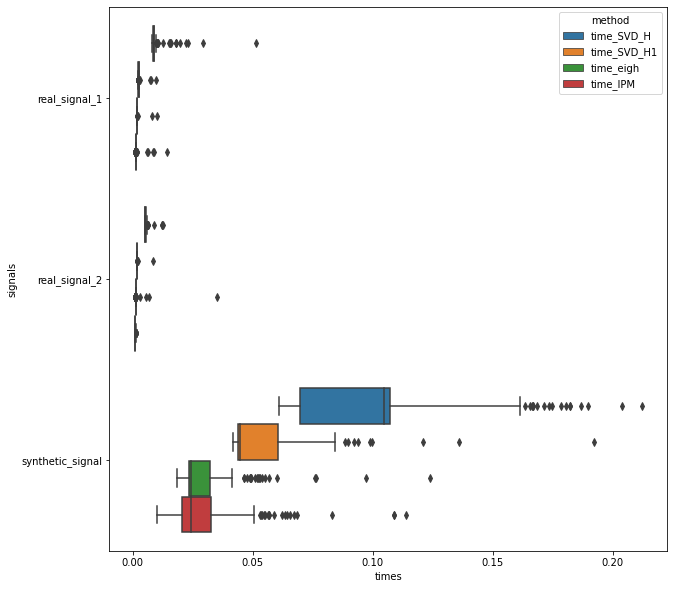

In [16]:
plt.figure(figsize = (10,10))
sns.boxplot(x = "times",
            y = "signals",
            data = df_times,
            hue = "method")

### Without outliers

<AxesSubplot:xlabel='times', ylabel='signals'>

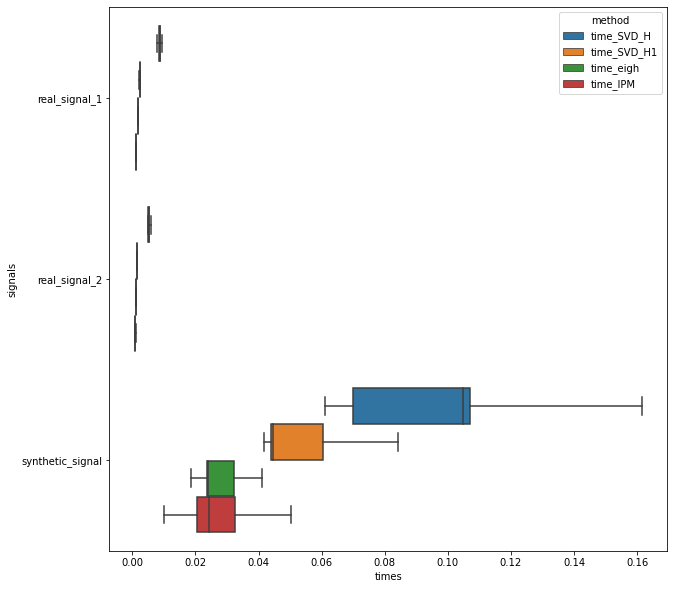

In [17]:
plt.figure(figsize = (10,10))
sns.boxplot(x = "times",
            y = "signals",
            data = df_times,
            hue = "method",
            showfliers = False)

In [18]:
df_times['method'].isin(["time_SVD_H1","time_eigh","time_IPM"])

0       False
1       False
2       False
3       False
4       False
        ...  
7195     True
7196     True
7197     True
7198     True
7199     True
Name: method, Length: 7200, dtype: bool

In [19]:
df_times2 = df_times[df_times['method'].isin(["time_eigh","time_IPM"])]

In [20]:
df_times2

,signals,method,times
3600,real_signal_1,time_eigh,0.002170
3601,real_signal_1,time_eigh,0.001739
3602,real_signal_1,time_eigh,0.001780
3603,real_signal_1,time_eigh,0.001781
3604,real_signal_1,time_eigh,0.001776
...,...,...,...
7195,synthetic_signal,time_IPM,0.058847
7196,synthetic_signal,time_IPM,0.037415
7197,synthetic_signal,time_IPM,0.024376
7198,synthetic_signal,time_IPM,0.056117


<AxesSubplot:xlabel='times', ylabel='signals'>

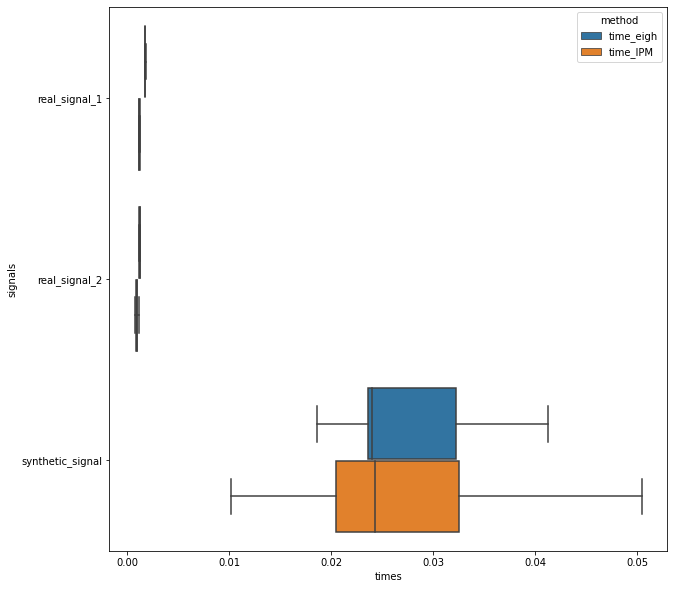

In [21]:
plt.figure(figsize = (10,10))
sns.boxplot(x = "times",
            y = "signals",
            data = df_times2,
            hue = "method",
            showfliers = False)

In [22]:
df_prom = df.groupby("signals").mean()
df_prom

,time_SVD_H,pTdotH_SVD_H,pTdotH1_SVD_H,time_SVD_H1,pTdotH_SVD_H1,pTdotH1_SVD_H1,time_eigh,pTdotH_eigh,pTdotH1_eigh,time_IPM,pTdotH_IPM,pTdotH1_IPM
signals,,,,,,,,,,,,
real_signal_1,0.008883,48.093876,2313.020908,0.002407,48.093876,2313.020908,0.001793,48.093876,2313.020908,0.001256,48.093876,2313.020908
real_signal_2,0.005264,1.746315,3.049616,0.001608,1.746315,3.049616,0.001272,1.746315,3.049616,0.000946,1.746315,3.049616
synthetic_signal,0.097148,0.097762,0.009557,0.052334,0.097762,0.009557,0.028571,0.097762,0.009557,0.027404,0.102408,0.010487


In [23]:
print(df_prom.style.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
 & time_SVD_H & pTdotH_SVD_H & pTdotH1_SVD_H & time_SVD_H1 & pTdotH_SVD_H1 & pTdotH1_SVD_H1 & time_eigh & pTdotH_eigh & pTdotH1_eigh & time_IPM & pTdotH_IPM & pTdotH1_IPM \\
signals &  &  &  &  &  &  &  &  &  &  &  &  \\
real_signal_1 & 0.008883 & 48.093876 & 2313.020908 & 0.002407 & 48.093876 & 2313.020908 & 0.001793 & 48.093876 & 2313.020908 & 0.001256 & 48.093876 & 2313.020908 \\
real_signal_2 & 0.005264 & 1.746315 & 3.049616 & 0.001608 & 1.746315 & 3.049616 & 0.001272 & 1.746315 & 3.049616 & 0.000946 & 1.746315 & 3.049616 \\
synthetic_signal & 0.097148 & 0.097762 & 0.009557 & 0.052334 & 0.097762 & 0.009557 & 0.028571 & 0.097762 & 0.009557 & 0.027404 & 0.102408 & 0.010487 \\
\end{tabular}



In [27]:
print(df_prom[["time_IPM","time_eigh","time_SVD_H1","time_SVD_H"]].style.to_latex())

\begin{tabular}{lrrrr}
 & time_IPM & time_eigh & time_SVD_H1 & time_SVD_H \\
signals &  &  &  &  \\
real_signal_1 & 0.001256 & 0.001793 & 0.002407 & 0.008883 \\
real_signal_2 & 0.000946 & 0.001272 & 0.001608 & 0.005264 \\
synthetic_signal & 0.027404 & 0.028571 & 0.052334 & 0.097148 \\
\end{tabular}

